In [9]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [10]:
!pip install livelossplot --quiet

import numpy as np
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

import torch
from torch.autograd import Variable

import torch.nn as nn 
import torch.nn.functional as F

from torchvision import transforms

from torch.utils import data
from sklearn.utils import shuffle

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler

from google.colab import files
import time

from math import exp
from mpl_toolkits import axes_grid1
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [11]:
# use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ' +str(device))

# set random seed for repeatibility
random_seed = 1
torch.backends.cudnn.enabled = False # disable cuDNN non-deterministic algorithms 
torch.manual_seed(random_seed)

# base folder
main_folder = "/content/drive/My Drive/HGM_programs/"

device: cuda


In [12]:
def data_range(photocurrents):
    """ Print photocurrents min, max and mean """
    if not(type(photocurrents)) == torch.Tensor:
        photocurrents = torch.from_numpy(photocurrents)
    photocurrents_min, photocurrents_max = torch.min(photocurrents), torch.max(photocurrents)
    print('({}, {}), mean of maxima:{}'.format(
        torch.min(photocurrents), torch.max(photocurrents), torch.mean(torch.max(photocurrents), 0)
        ))

def resize(a_tensor, output_base):
    ''' Reshape a tensor from (n_samples, width, heigth) to (n_samples, output_base, output_base) '''
    resize_transform = transforms.Compose([transforms.Resize((output_base, output_base))])
    return resize_transform(a_tensor)

def normalize_data_sigmoid(data_to_norm, max_power_factor=50): #10 choose to have max of data (or most data) in (0,1)
    """ Normalize data in range (0,1) for NN """
    power = torch.sum(torch.sum(data_to_norm, axis=1), axis=1)
    epsilon = 1e-20
    return max_power_factor * data_to_norm / (power.reshape(-1,1,1) + epsilon)

def normalize_data_photocurrent(data_to_norm):
    """ Normalize data in range (0,1) for NN """
    power = torch.sum( data_to_norm[:, ::2,]**2 + data_to_norm[:, 1::2,]**2, axis=1 ) 
    data_to_norm = data_to_norm / torch.sqrt(power).reshape(-1,1)
    return data_to_norm, power.reshape(-1,1)

def flat(I_HG_tensor):
    """ (n_samples, x, y) --> (n_samples, x * y) """
    return I_HG_tensor.reshape(I_HG_tensor.shape[0], -1)

def concate_pad_images(images, padding):
    """ Return the complete image from its pieces which have padding. 
    Args:
        images -- tensor (num_img_along_x, num_img_along_y, size_img_x, size_img, y)
        note: size_img_x = x_square_no_pad+padding
    Outputs:
        img_tot -- matrix (num_img_x*x_square_no_pad+padding, num_img_y*y_square_no_pad+padding, y)
    """
    num_img_x, num_img_y = images.shape[0], images.shape[1]
    x_square, y_square = images.shape[2], images.shape[3]
    x_square_no_pad, y_square_no_pad = x_square-padding, y_square-padding
    
    img_tot = np.zeros(( num_img_x*x_square_no_pad+padding, num_img_y*y_square_no_pad+padding ))

    count=0
    for i in range(num_img_y):
        for j in range(num_img_x):
            #print(j,i)
            img_tot[j*y_square_no_pad:j*y_square_no_pad+y_square, i*x_square_no_pad:i*x_square_no_pad+x_square] += \
                images[j,i,:,:]
            count+=1
    # print('images concatenated removing padding: '+str(count))
    grid_y, grid_x = [], [] # save single frames borders position to later save them
    for i in range(num_img_y+2):
        grid_y.append(i*x_square_no_pad+int(padding/2))
    for j in range(num_img_x+2):
        grid_x.append(j*y_square_no_pad+int(padding/2))
    return img_tot, grid_x, grid_y

def get_real_imag(a_tensor, m,n, part, HG_basis=15):
    '''
    Return the real or imag photocurrent amplitude for a given mode (m,n) from a tensor of size (n_samples, 512).
    '''
    if part == 'real':
        return a_tensor[:, HG_basis*2*m+n*2]
    elif part == 'imag':
        return a_tensor[:, HG_basis*2*m+n*2+1]
    else:
        raise "variable part must be either 'real' or 'imag'."

def get_power(a_tensor, m,n):
    '''
    Return the photocurrent power for a given mode (m,n) from a tensor of size (n_samples, HG_basis*HG_basis*2).
    '''
    return get_real_imag(a_tensor,m,n,'real',HG_basis=15)**2 + get_real_imag(a_tensor, m,n,'imag',HG_basis=15)**2

def substitute_nan_with_zeros(a_tensor):
    ''' Check if there are 'nan' and substitute them with zeros. '''
    print('number of nan: {}'.format(torch.sum( torch.isnan(a_tensor) )))
    a_tensor[a_tensor != a_tensor] = 0 
    return a_tensor

def get_tensor_max_avg(a_tensor):
    '''
    Given a tensor (n_samples, *dim) return the samples max and average:

    Returns:
        tensor_max_temp (arr) - max of each sample. arr of dimension (n_samples)
        tensor_avg_temp (arr) - mean of each sample. arr of dimension (n_samples)
    '''
    one_tensor_dim = len(a_tensor.shape)
    tensor_max_temp, tensor_avg_temp = a_tensor, a_tensor
    for i in range(one_tensor_dim-1):
        tensor_max_temp, idx_max = torch.max(tensor_max_temp, dim=1)
        tensor_avg_temp = torch.mean(tensor_avg_temp, dim=1)
    return tensor_max_temp, tensor_avg_temp

def tensor_cat(names, folder, output_base=None, normalize=True, repetition=None):
    ''' Concatenate dataset tensors included in the list names and normalize them. '''

    list_of_tensors = []
    for name in names:
        if repetition is not None:
            loaded_tensor = torch.load(folder + '/repeated_acquisitions/'+ str(repetition) + '/'+ str(name)+'.pt')
        else:
            print(folder + '/'+str(name)+'.pt')
            loaded_tensor = torch.load(folder + '/'+str(name)+'.pt')

        list_of_tensors.append(loaded_tensor)

    final_tensor = torch.cat(list_of_tensors, dim=0)

    if output_base:
        final_tensor = resize(final_tensor, output_base)

    power = None
    
    if normalize:
        if 'photocurrents' in folder:
            print('normalizing photocurrents for {}'.format(names))
            final_tensor, power = normalize_data_photocurrent( final_tensor )
        else:
            final_tensor = normalize_data_sigmoid( final_tensor )

    return final_tensor, power


def features_and_labels(names, features_folder, labels_folder, output_base=None, repetition=None, normalize=True):
    '''
    Load features (experimental photocurrents) and label (simulated images reconstructed via HG microscopy) 
    
    Args:
        names - list of (str), name of datasets to load
        features_folder - path to folder where processed exp photocurrents (torch tensors) are stored
        labels_folder - path to folder where processed simulated images via HG microscopy (torch tensors) are stored

        repetition (bool) - True if measurement was acquired several times, othewise False
        normalize (bool) - set True to perform normalization 
    '''
    features, power = tensor_cat(names, features_folder, normalize=normalize, repetition=repetition)
    labels, _ = tensor_cat(names, labels_folder, output_base=output_base, normalize=normalize, repetition=repetition)
    return features, labels, power

In [13]:
def get_idx(modes_to_select, modes_total):
    ''' Select index from array of real and imag photocurrents. '''
    idx = []
    for i in range(modes_total):
        start = i*modes_total*2
        stop = i*modes_total*2+modes_to_select*2
        idx.extend(np.arange(start,stop,1) )  

    idx = idx[:modes_to_select*modes_to_select*2]
    return idx

def photocurrents_base_select(feature_tensor, modes_to_select, modes_experiment):
    modes_to_select = int(modes_to_select)+1
    modes_experiment = int(modes_experiment)+1

    idx = get_idx(modes_to_select, modes_experiment)
    return feature_tensor[:,idx]

Load exp photocurrents (features) and simulated HG reconstructed images (labels)

In [17]:
## ----------- Settings -----------

## .......... LO modes ..........
features_LO_selected = '8' # select a subset of photocurrents from the experimental photocurrents (e.g. 5x5 from 20x20) 

features_LO = '20' # performed experiment (e.g. done in 20x20 modes)
label_LO = features_LO_selected # LO modes used to reconstruct image label, e.g. ''20x20'

### .......... output images size ..........
image_size = None # leave None to avoid any resize operation. The pre-saved NN labels are 50x50 images

## .......... Training set ....................
names = list()
names.append('square')
names.append('square_part')
names.append('rand_matrix')
# names.append('lines_pair') # excluded from training set so  we can evaluate super-res using naive Rayleigh criterion 
names.append('rand_line')
names.append('rand_lines')
names.append('rand_ellipse')
names.append('rand_ellipses')

## ----------- end of Settings -----------

data_folder = f'{main_folder}/data'
features_path = f'{data_folder}/exp_photocurrents'
labels_path = f'{data_folder}/sim_HG_reconstruction/{label_LO}x{label_LO}'

result_folder = f'{main_folder}/neural_network/predictions/{label_LO}x{label_LO}'

# Train/dev dataset
train_features, train_labels, train_power = features_and_labels(names, features_path, labels_path, output_base=image_size, normalize=True)

# Test datasets
logo_features, logo_labels, logo_power = features_and_labels(['logo'], features_path, labels_path, output_base=image_size, normalize=True)
logo_full_features, logo_full_labels, logo_full_power = features_and_labels(['logo_full'], features_path, labels_path, output_base=image_size, normalize=True)
alphabet_features, alphabet_labels, alphabet_power = features_and_labels(['alphabet'], features_path, labels_path, output_base=image_size, normalize=True)
lines_features, lines_labels, lines_power = features_and_labels(['lines_rayleigh'], features_path, labels_path, output_base=image_size, normalize=True)

# Select a subset of the photocurrents (i.e. 5x5 from 20x20 acquisition)
train_features = photocurrents_base_select(train_features, features_LO_selected, features_LO)
logo_features = photocurrents_base_select(logo_features, features_LO_selected, features_LO)
logo_full_features = photocurrents_base_select(logo_full_features, features_LO_selected, features_LO)
alphabet_features = photocurrents_base_select(alphabet_features, features_LO_selected, features_LO)
lines_features = photocurrents_base_select(lines_features, features_LO_selected, features_LO)

/content/drive/My Drive/HGM_programs//data/exp_photocurrents/square.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/square_part.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/rand_matrix.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/rand_line.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/rand_lines.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/rand_ellipse.pt
/content/drive/My Drive/HGM_programs//data/exp_photocurrents/rand_ellipses.pt
normalizing photocurrents for ['square', 'square_part', 'rand_matrix', 'rand_line', 'rand_lines', 'rand_ellipse', 'rand_ellipses']
/content/drive/My Drive/HGM_programs//data/sim_HG_reconstruction/8x8/square.pt
/content/drive/My Drive/HGM_programs//data/sim_HG_reconstruction/8x8/square_part.pt
/content/drive/My Drive/HGM_programs//data/sim_HG_reconstruction/8x8/rand_matrix.pt
/content/drive/My Drive/HGM_programs//data/sim_HG_reconstruction/8x8/rand_line.pt
/content/driv

In [18]:
print('features train/dev dataset shape: ',train_features.shape)
print('label train/dev dataset shape: ',train_labels.shape)

features train/dev dataset shape:  torch.Size([26501, 162])
label train/dev dataset shape:  torch.Size([26501, 50, 50])


**Inputs (photocurrents)**

Since we use tanh, average should be around 0 (where grad is max), and most values in (-1, 1), where grad is still high

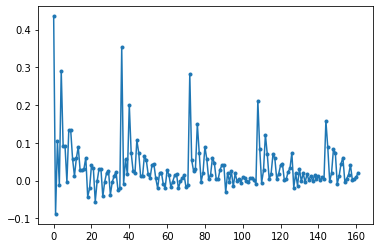

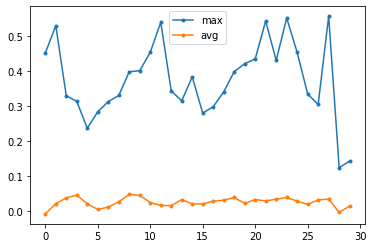

In [19]:
idx = 20
plt.plot(logo_features[idx,:], '.-')
plt.show()

# idx = 100
# plt.plot(train_features[idx,:], '.-')
# plt.show()

max_feature, avg_feature = get_tensor_max_avg(logo_features)
plt.plot(max_feature, '.-', label='max')
plt.plot(avg_feature, '.-', label='avg')
plt.legend()
plt.show()

**Labels (reconstructed images, simulated)**

Since we use sigmoid at the NN output layer, average should be around 0.5 (where grad is max) and min/max in (0,1)

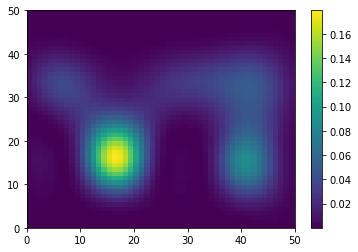

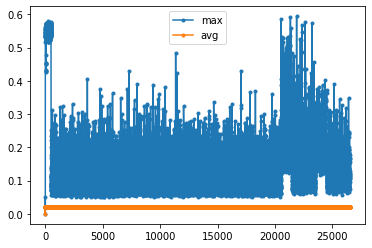

In [21]:
idx = 22
plt.pcolormesh(logo_labels[idx,:,:])
plt.colorbar()
plt.show()

max_feature, avg_feature = get_tensor_max_avg(train_labels)
plt.plot(max_feature, '.-', label='max')
plt.plot(avg_feature, '.-', label='avg')
plt.legend()
plt.show()

# experimental power (sum of squared photocurrents)
# plt.plot(train_power, '.-')
# plt.show()

In [22]:
class TrainDevDataset(Dataset):
    def __init__(self, transform=None, data_dir=None):
        self.transform = transform
        self.features = train_features.float()
        self.labels = flat(train_labels).float()
    def __getitem__(self, index):
        features = self.features[index]
        labels = self.labels[index]
        return (features, labels) 
    def __len__(self):
        return len(self.features)

class LogoDataset(Dataset):
  def __init__(self, transform=None, data_dir=None):
      self.transform = transform
      self.features = logo_features.float()
      self.labels = flat(logo_labels).float() 
  def __getitem__(self, index):
      features = self.features[index]
      labels = self.labels[index]
      return (features, labels)
  def __len__(self):
      return len(self.features)

class AlphabetDataset(Dataset):
  def __init__(self, transform=None, data_dir=None):
      self.transform = transform
      self.features = alphabet_features.float()
      self.labels = flat(alphabet_labels).float() 
  def __getitem__(self, index):
      features = self.features[index]
      labels = self.labels[index]
      return (features, labels)
  def __len__(self):
      return len(self.features)

class LogoFullDataset(Dataset):
  def __init__(self, transform=None, data_dir=None):
      self.transform = transform
      self.features = logo_full_features.float()
      self.labels = flat(logo_full_labels).float() 
  def __getitem__(self, index):
      features = self.features[index]
      labels = self.labels[index]
      return (features, labels)
  def __len__(self):
      return len(self.features)

class LinesDataset(Dataset):
  def __init__(self, transform=None, data_dir=None):
      self.transform = transform
      self.features = lines_features.float()
      self.labels = flat(lines_labels).float() 
  def __getitem__(self, index):
      features = self.features[index]
      labels = self.labels[index]
      return (features, labels)
  def __len__(self):
      return len(self.features)

train_dev_dataset = TrainDevDataset('Train and Dev DataSet')

logo_dataset = LogoDataset('Oxford logo dataset') 
alphabet_dataset = AlphabetDataset('Alphabet dataset') 
logo_full_dataset = LogoFullDataset('Logo with motto - coat of arms - dataset') 
lines_dataset = LinesDataset('Vertical Lines dataset') 

train_part, dev_part  = 0.90, 0.10 
size_dataset = train_features.shape[0]
train_ratio = int(np.ceil(size_dataset*train_part))
dev_ratio = size_dataset - train_ratio

train_set, dev_set = torch.utils.data.random_split(train_dev_dataset, [train_ratio, dev_ratio])
print(f'train set len: {len(train_set)}')
print(f'dev set len: {len(dev_set)}')

def set_loader(batch_size, loader_name):
  if loader_name == 'train':
    current_set = train_set
  elif loader_name == 'dev':
    current_set = dev_set

  elif loader_name == 'logo':
    current_set = logo_dataset
  elif loader_name == 'alphabet':
    current_set = alphabet_dataset

  elif loader_name == 'lines':
    current_set = lines_dataset
  elif loader_name == 'logo_full':
    current_set = logo_full_dataset

  return DataLoader(
    current_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers=0)

train set len: 23851
dev set len: 2650


In [23]:
# model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # creates an instance of the base nn.Module class

        n = 6000 #4000
        n1, n2 = n, n

        # 20x20
        input_data_size = ((int(features_LO_selected)+1)**2)*2
        self.fc1 = nn.Linear(input_data_size, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 2500) # output image 50x50
        # droput 20% of hidden units, randomly (Bernoulli)
        # nn.Dropout : during evaluation, dropout turned off automatically
        # self.dropout = nn.Dropout(p=0)

    def forward(self, x):
        x = torch.tanh( self.fc1(x) )  # first activation function tanh : photocurrents are positive and negative values
        x = torch.relu( self.fc2(x) )  # second ReLU : training faster
        x = torch.sigmoid( self.fc3(x) ) # sigmod : output max = 1 (like images target dataset)
        return x 

In [24]:
# train
def train_model(model, criterion, optimizer, batch_size, loss_vs_epoch, num_epochs=10, name_test='', save_at_epoch=[]):
    # liveloss = PlotLosses()
    result_folder = f'{main_folder}/neural_network/predictions/{name_test}'

    model = model.to(device)
    
    dataloaders = {
      "train": set_loader(batch_size, 'train'), # train
      "dev": set_loader(batch_size, 'dev'), #dev
      "alphabet": set_loader(len(alphabet_dataset), 'alphabet') #dev
    }

    for epoch in range(num_epochs):
        logs = {}

        for phase in ['train', 'dev', 'alphabet']: 

            if phase == 'train':
                model.train()
            else: # no backprop (grads not updated)
                model.eval() 

            running_loss = 0.0

            number_of_samples = len(dataloaders[phase].dataset)

            for inputs, targets in dataloaders[phase]: # loop over batches

                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs) # forward prop

                loss = criterion(outputs, targets) # calculate loss

                if phase == 'train':
                    optimizer.zero_grad() # zero grad before each mini-batch
                    loss.backward() # backprop
                    optimizer.step()

                running_loss += loss.detach() # targets.size(0)

            epoch_loss = running_loss / number_of_samples
            loss_vs_epoch[phase].append(epoch_loss)

        if epoch in save_at_epoch:
            print('epoch {}'.format(epoch))
                
            torch.save(loss_vs_epoch['train'], f'{result_folder}/train_loss.pt')
            torch.save(loss_vs_epoch['dev'], f'{result_folder}/dev_loss.pt')
            torch.save(loss_vs_epoch['alphabet'], f'{result_folder}/alphabet_loss.pt')

            if epoch == 900:
                torch.save(model.state_dict(), f'{result_folder}/{epoch}.pth')

            # plt.plot(np.log10(loss_vs_epoch['train']), '.', label='train')
            # plt.plot(np.log10(loss_vs_epoch['dev']), 'x', label='validation')
            # plt.plot(np.log10(loss_vs_epoch['alphabet']), 'o', label='alphabet')
            # plt.show()


def custom_train_model(model, loss_vs_epoch, num_epochs=101, learning_rate=5e-2, batch_size=32, name_test='', save_at_epoch=[]):
  criterion = nn.MSELoss(reduction='mean') 
  # criterion = MSSSIM()

  optimizer = torch.optim.Adam(
      model.parameters(),
      lr= learning_rate,
      betas=(0.9, 0.999),
      eps=1e-08,
      weight_decay= 0, #.0005,
      amsgrad=False
  )
  return train_model(model, criterion, optimizer, batch_size, loss_vs_epoch, num_epochs=num_epochs, name_test=name_test, save_at_epoch=save_at_epoch)

Train the model

In [25]:
# re-initialize the model 
# del model
model = Net()

In [26]:
name_test = f'{features_LO_selected}x{features_LO_selected}' 

save_at_epoch = np.arange(0,1100,50)

dev_loss, train_loss, alphabet_loss = [], [], []

loss_vs_epoch = {
    'train' : [],
    'dev' : [],
    'alphabet' : []
}

custom_train_model(
    model, 
    loss_vs_epoch,
    num_epochs = save_at_epoch[-1],
    learning_rate = 1e-4, 
    batch_size = 512,
    name_test=name_test,
    save_at_epoch = save_at_epoch
)

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950
epoch 1000


ValueError: ignored

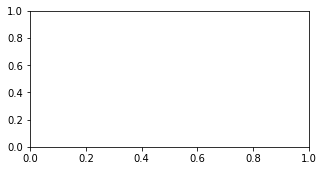

In [31]:
# check loss vs epoch
epochs = np.arange(0,1001,1)

if device.type == 'cpu':    
    train_loss = torch.load(f'{result_folder}/train_loss.pt', map_location=torch.device('cpu'))
    dev_loss = torch.load(f'{result_folder}/dev_loss.pt', map_location=torch.device('cpu'))
    alphabet_loss = torch.load(f'{result_folder}/alphabet_loss.pt', map_location=torch.device('cpu'))

else: # gpu
    train_loss = torch.load(f'{result_folder}/train_loss.pt')
    dev_loss = torch.load(f'{result_folder}/dev_loss.pt')
    alphabet_loss = torch.load(f'{result_folder}/alphabet_loss.pt')

fig = plt.figure(figsize=(5, 2.5))

plt.plot(epochs, np.log10(train_loss), '.', label='train')
plt.plot(epochs, np.log10(dev_loss[:]), 'x', label='validation')
plt.plot(epochs, np.log10(alphabet_loss[:]), 'o', label='alphabet')

plt.gca().set_xticks(np.arange(min(epochs), 1001, 250))
plt.gca().xaxis.set_minor_locator(MultipleLocator(50))


font = {'family':'sans-serif', 'sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

plt.ylim(-7, -5)
plt.gca().set_yticks(np.arange(-7.0, -4.9, 1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))

plt.axvline(x=900, linestyle='dashed', c='grey')
# plt.xlabel('epoch')
# plt.ylabel('Log10( MSE loss )')
# plt.legend()
plt.show()

print(np.log10(train_loss[900].cpu()))
print(np.log10(dev_loss[900].cpu()))

Evalute the model on test dataset

In [28]:
def select_database(db_name):
    ''' Returns an iterator over a database given its name '''
    if db_name == 'logo':
        return iter(set_loader(1, 'logo')), logo_power, 3, 10
    elif db_name == 'logo_full':
        return iter(set_loader(1, 'logo_full')), logo_full_power, 12, 10
    elif db_name == 'lines':
        return iter(set_loader(1, 'lines')), lines_power, 4, 14 
    elif db_name == 'alphabet':
        return iter(set_loader(1, 'alphabet')), alphabet_power, 10, 10 
    else:
        print('Database name is wrong')
        pass

def evaluate_model_and_compose_img(dataset_name, save_prediction=False):
    ''' 
    Given a dataset name, evaluate the trained model over its samples (single frames) and return the predictions and labels already composed in a single image.

    Args:
        dataset_name - string, e.g. 'logo', 'logo_full', 'alphabet', 'lines'
    Returns: 
        complete_img - image composed of NN frames predictions  
        grid_x, grid_y - array which indicate the borders between the frames, useful for plotting
        complete_img_label - image composed of NN frames labels 
        grid_x_label, grid_y_label - array which indicate the borders between the frames, useful for plotting
    '''

    it, power, n_img_x, n_img_y = select_database(dataset_name)

    n_samples = len(it) #n_samples = 30

    E_reconstructed_NN = np.zeros((n_samples, size_img, size_img))
    E_HG_label = np.zeros((n_samples, size_img, size_img))

    images_HG =  np.zeros((n_img_x, n_img_y, size_img, size_img))
    targets =  np.zeros((n_img_x, n_img_y, size_img, size_img))

    predictions = np.zeros((n_img_x*n_img_y, size_img, size_img))
    labels = np.zeros((n_img_x*n_img_y, size_img, size_img))

    for i in range(0, n_samples):
        j_one, target  = next(it)

        model.eval()
        out = model(j_one.to(device))

        E_reconstructed_NN_flat = out.detach().cpu().numpy().reshape(-1, 1)
        E_HG_label_flat = target.cpu().numpy().reshape(-1, 1)

        E_reconstructed_NN[i, :, :] = E_reconstructed_NN_flat.reshape(size_img, size_img)
        E_HG_label[i, :, :] = E_HG_label_flat.reshape(size_img, size_img)

        x_i = np.mod(i,n_img_y)
        y_i = int(i/n_img_y )             

        images_HG[ y_i, x_i, :, :] = E_reconstructed_NN[i, :, :] * power[i].detach().cpu().numpy()
        targets[ y_i, x_i, :, :] = E_HG_label[i, :, :] * power[i].detach().cpu().numpy()

        predictions[i,:,:] = images_HG[ y_i, x_i, :, :]
        labels[i,:,:] = targets[ y_i, x_i, :, :]

    if save_prediction:
        torch.save(predictions, f'{result_folder}/{dataset_name}_prediction.pt')
        torch.save(labels, f'{result_folder}/{dataset_name}_label.pt')

    complete_img, grid_x, grid_y = concate_pad_images( images_HG, padding)
    complete_img_label, grid_x_label, grid_y_label = concate_pad_images( targets, padding)

    return complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label


def plot_prediction_and_label(complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label, transparency = 0.2, plot_only_prediction=False):
    ''' Plot the NN prediction and its label '''

    if plot_only_prediction:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1)

        plt.pcolormesh(complete_img)
        plt.gca().set_aspect('equal')

        for sep in grid_x:
            plt.axhline(y=sep, color=(0, 0, 0, transparency), linestyle='-')
        for sep in grid_y:
            plt.axvline(x=sep, color=(0, 0, 0, transparency), linestyle='-')

        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False, # labels along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off

        plt.ylim(grid_x[0],grid_x[-2])
        plt.xlim(grid_y[0],grid_y[-2])

        plt.show()

    else:
        fig = plt.figure(figsize=(18, 10))
        ax = fig.add_subplot(1, 2, 1)

        plt.pcolormesh(complete_img)
        plt.title('NN prediction')
        plt.gca().set_aspect('equal')

        for sep in grid_x:
            plt.axhline(y=sep, color=(0, 0, 0, transparency), linestyle='-')
        for sep in grid_y:
            plt.axvline(x=sep, color=(0, 0, 0, transparency), linestyle='-')

        plt.ylim(grid_x[0],grid_x[-2])
        plt.xlim(grid_y[0],grid_y[-2])

        ax = fig.add_subplot(1, 2, 2)
        plt.pcolormesh(complete_img_label)
        plt.title('NN label')
        plt.gca().set_aspect('equal')
        images_dir = main_folder+'results/'

        for sep in grid_x_label:
            plt.axhline(y=sep, color=(0, 0, 0, transparency), linestyle='-')
        for sep in grid_y_label:
            plt.axvline(x=sep, color=(0, 0, 0, transparency), linestyle='-')
        plt.ylim(grid_x_label[0],grid_x_label[-2])
        plt.xlim(grid_y_label[0],grid_y_label[-2])

        # plt.colorbar()
        plt.show()

Test model over a dataset

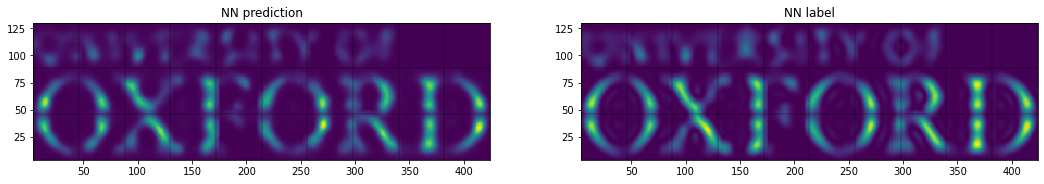

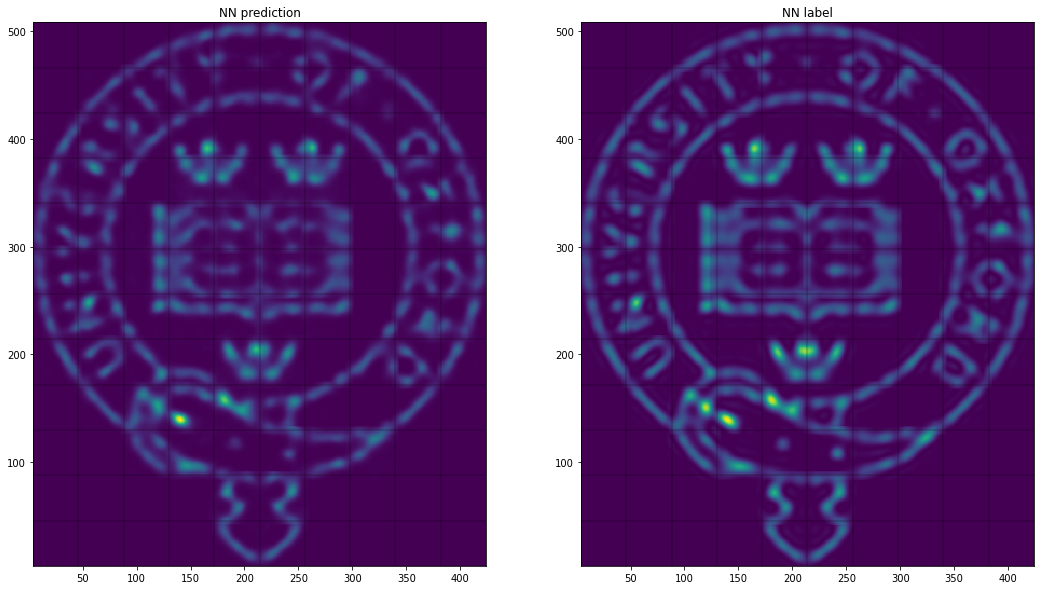

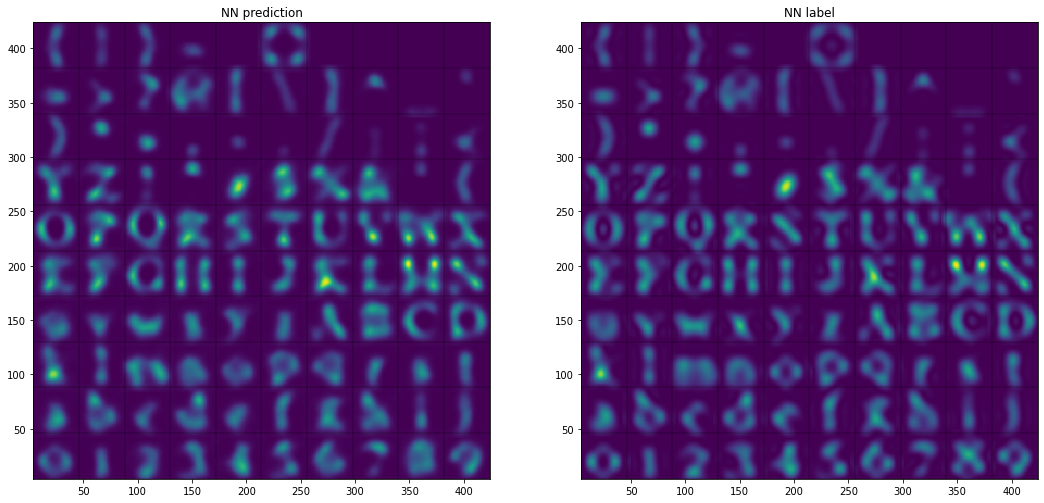

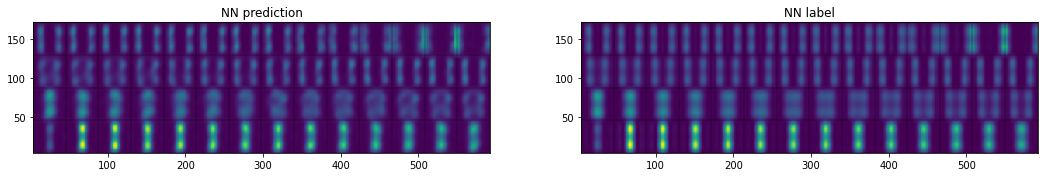

In [35]:
## load saved NN model and set it to evaluation mode (weights not updated)
epochs_partial = 900

del model
model = Net()
model_name = f'{result_folder}/{epochs_partial}.pth'

if device.type == 'cpu':
    model.load_state_dict(torch.load( model_name, map_location=torch.device('cpu')))
else: #gpu
    model.load_state_dict(torch.load( model_name ))

model = model.to(device)
model.eval()

## images concatenation settings
padding = 8
size_img = 50
## --------------------------------------

# select a dataset to test among:
# 'logo'
# 'logo_full'
# 'alphabet'
# 'lines'

complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label = evaluate_model_and_compose_img('logo', save_prediction=True)
plot_prediction_and_label(complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label, transparency = 0.2)

complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label = evaluate_model_and_compose_img('logo_full', save_prediction=True)
plot_prediction_and_label(complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label, transparency = 0.2)

complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label = evaluate_model_and_compose_img('alphabet', save_prediction=True)
plot_prediction_and_label(complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label, transparency = 0.2)

complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label = evaluate_model_and_compose_img('lines', save_prediction=True)
plot_prediction_and_label(complete_img, grid_x, grid_y, complete_img_label, grid_x_label, grid_y_label, transparency = 0.2)

**Figure 2 paper**

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.special import factorial

In [ ]:
print(features_path)
print(labels_path)

# Train datasets
train_features_for_img, train_labels_for_img, train_power_for_img = features_and_labels(['rand_matrix'], features_path, labels_path, normalize=True)
# Test datasets
logo_features_for_img, logo_labels_for_img, logo_power_for_img = features_and_labels(['logo'], features_path, labels_path, normalize=True)

/content/drive/My Drive/HGM_programs//data/exp_photocurrents
/content/drive/My Drive/HGM_programs//data/sim_HG_reconstruction/20x20
normalizing photocurrents for ['rand_matrix']
normalizing photocurrents for ['logo']


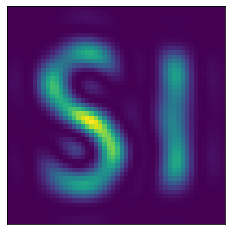

In [ ]:
sample_idx = 100 ## usatd as training set example
sample_idx_test = 24 ## usatd as test set example

plt.pcolormesh(logo_labels_for_img[sample_idx_test])
# plt.pcolormesh(train_labels_for_img[sample_idx])

plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().set_xticks(range(0,100,5))
# plt.gca().set_yticks(range(0,100,5))

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False, # labels along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off


img_half_size = 25
min_img, max_img = 25-img_half_size,25+img_half_size
plt.xlim(min_img, max_img)
plt.ylim(min_img, max_img)

plt.show()

# photocurrents, label = set_loader(1, 'train').dataset[-1]

###################### choose a sample #########################################
# photocurrents = train_features_for_img[sample_idx,:].double()
photocurrents = logo_features_for_img[sample_idx_test,:].double()
########################################################################################

abs_photocurrents = np.sqrt( photocurrents[::2]**2 + photocurrents[1::2]**2 ).reshape(21,21)
angle_photocurrents = np.angle( photocurrents[::2] + 1j*photocurrents[1::2] ).reshape(21,21)

Text(0, 0.5, 'n')

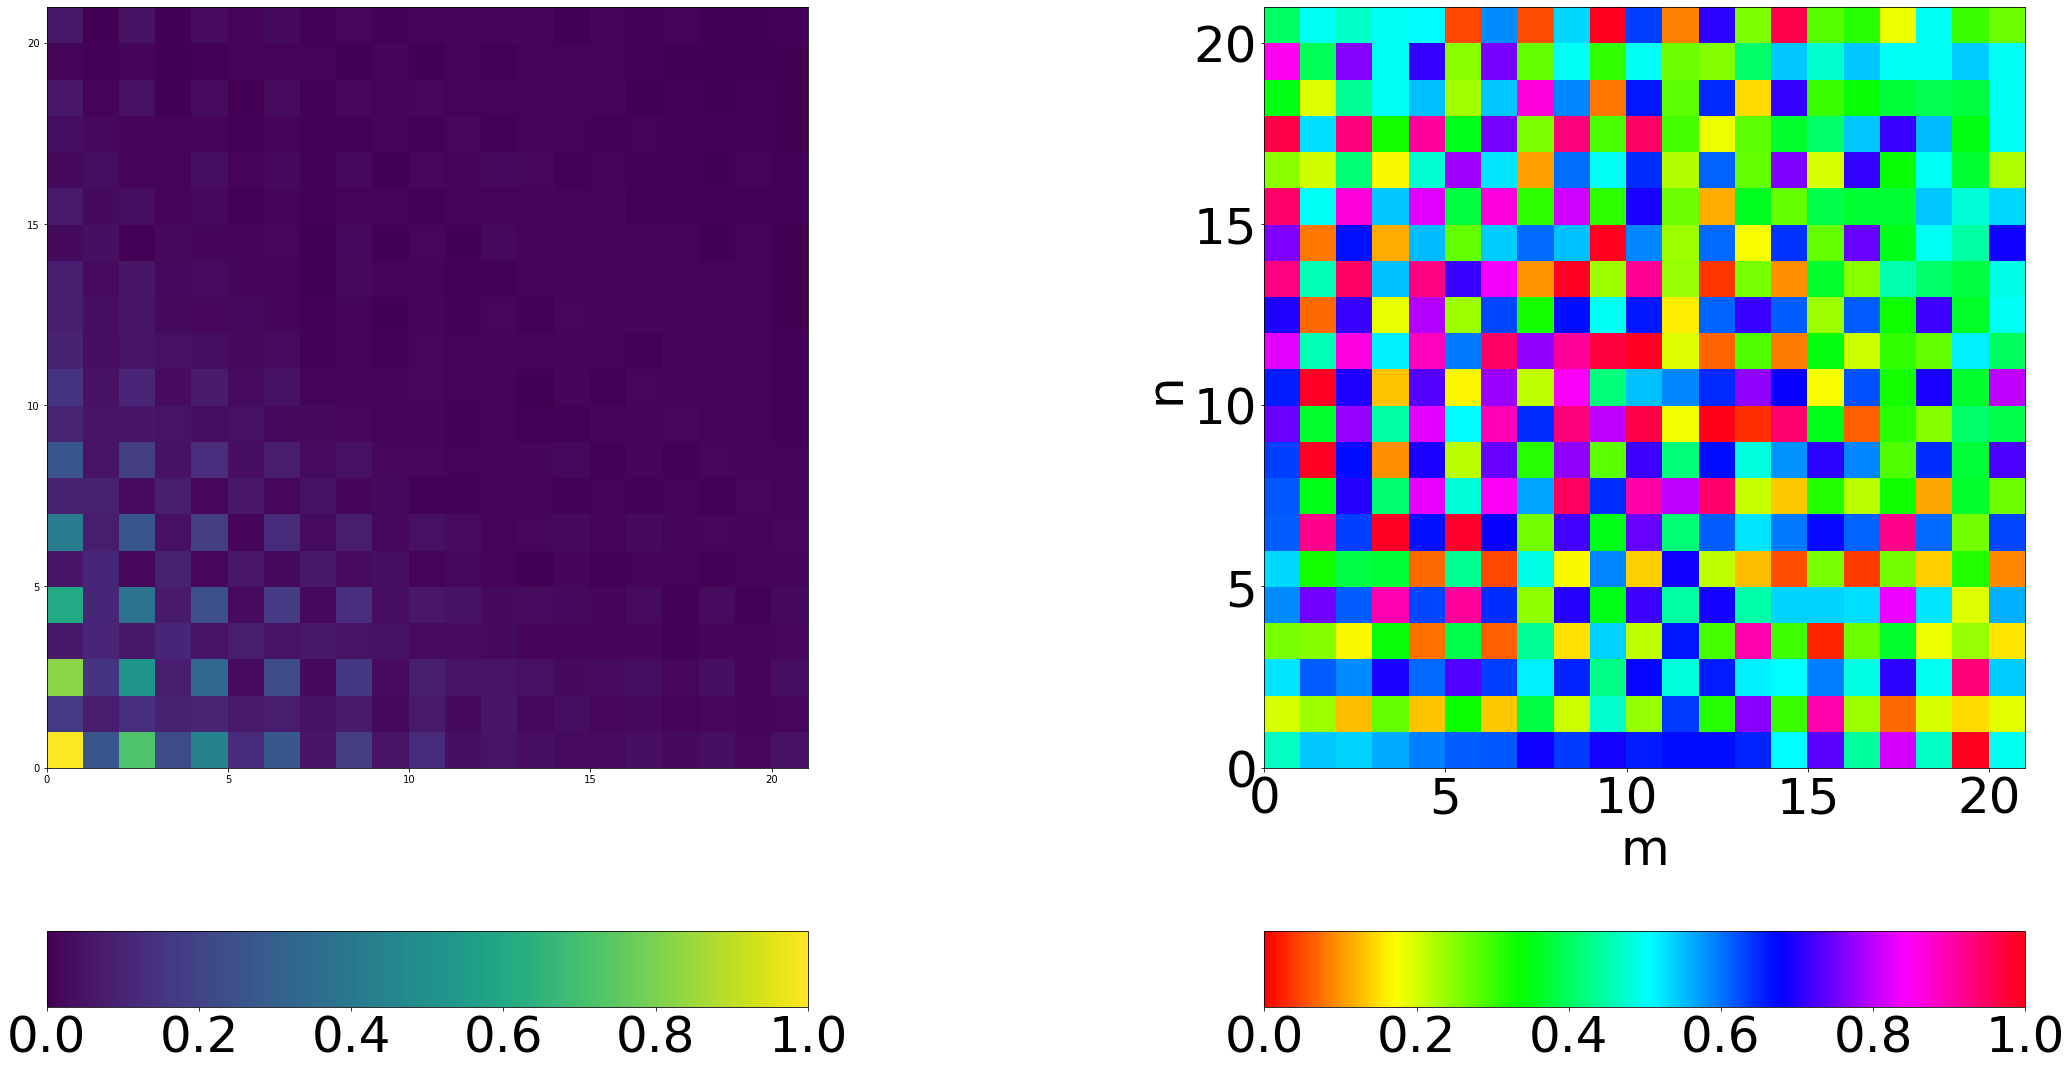

In [ ]:
### figure style ###
colormap_abs = cm.viridis
colormap_phase = cm.hsv

tics = range(0,21+1,5)

#######################################
fig = plt.figure(figsize=(40, 20))

plt.subplot(1,2,1)

font = {'family':'sans-serif', 'sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 50}

plt.rc('font', **font)


plt.pcolormesh(abs_photocurrents*1, cmap=colormap_abs)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_xticks(tics)
plt.gca().set_yticks(tics)

m = plt.cm.ScalarMappable(cmap=colormap_abs)
plt.colorbar(m, shrink=0.75, aspect=10, orientation='horizontal')

plt.subplot(1,2,2)
plt.pcolormesh(angle_photocurrents+np.pi, cmap=colormap_phase, vmin=0, vmax=2*np.pi)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_xticks(tics)
plt.gca().set_yticks(tics)

m = plt.cm.ScalarMappable(cmap=colormap_phase)
plt.colorbar(m, shrink=0.75, aspect=10, orientation='horizontal')

plt.xlabel('m')
plt.ylabel('n')

In [ ]:
size_img = 50

E_reconstructed_NN = np.zeros((size_img, size_img))
E_HG_label = np.zeros((size_img, size_img))

model.eval()
model = model.double()
out = model(photocurrents.to(device))

E_reconstructed_NN_flat = out.detach().cpu().numpy().reshape(-1, 1)
# E_HG_label_flat = target.cpu().numpy().reshape(-1, 1)

E_reconstructed_NN[:, :] = E_reconstructed_NN_flat.reshape(size_img, size_img)
# E_HG_label[:, :] = E_HG_label_flat.reshape(size_img, size_img)

images_HG = E_reconstructed_NN[:, :]

RuntimeError: ignored

In [ ]:
### figure style ###
colormap_abs = cm.viridis

tics = range(0,21+1,5)

#######################################
fig = plt.figure(figsize=(10, 5))
font = {'family':'sans-serif', 'sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)


plt.pcolormesh(images_HG*1, cmap=colormap_abs)
plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().set_xticks(range(0,100,5))
# plt.gca().set_yticks(range(0,100,5))

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False, # labels along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off


img_half_size = 25
min_img, max_img = 25-img_half_size,25+img_half_size
plt.xlim(min_img, max_img)
plt.ylim(min_img, max_img)

NameError: ignored

<Figure size 720x360 with 0 Axes>

**Check input and output statistics: check data is normalized so train is fast**


In [ ]:
def get_tensor_max_avg(a_tensor):
    '''
    Given a tensor (n_samples, *dim) return the samples max and average:

    Returns:
        tensor_max_temp (arr) - max of each sample. arr of dimension (n_samples)
        tensor_avg_temp (arr) - mean of each sample. arr of dimension (n_samples)
    '''
    one_tensor_dim = len(a_tensor.shape)
    tensor_max_temp, tensor_avg_temp = a_tensor, a_tensor
    for i in range(one_tensor_dim-1):
        tensor_max_temp, idx_max = torch.max(tensor_max_temp, dim=1)
        tensor_avg_temp = torch.mean(tensor_avg_temp, dim=1)
    return tensor_max_temp, tensor_avg_temp

**Inputs (photocurrents)**

Since we use tanh, average should be around 0 (where grad is max), and most values in (-1, 1), where grad is still high

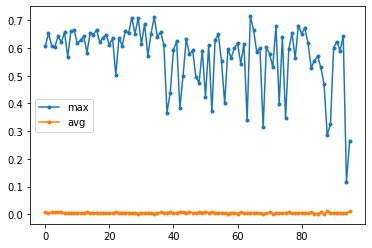

In [ ]:
max_feature, avg_feature = get_tensor_max_avg(alphabet_features)
plt.plot(max_feature, '.-', label='max')
plt.plot(avg_feature, '.-', label='avg')
plt.legend()

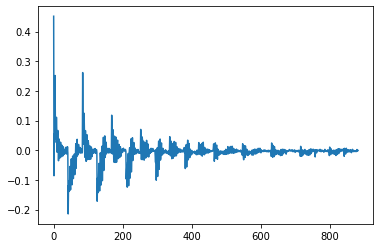

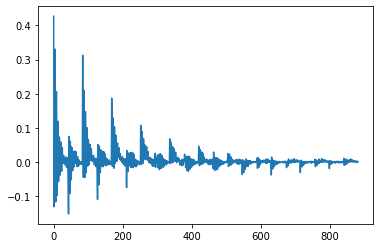

In [ ]:
idx = 0
plt.plot(logo_features[idx,:])
plt.show()

idx = 23000
plt.plot(train_features[idx,:])#*train_features[idx])
plt.show()

**Labels (reconstructed images, simulated)**

Since we use sigmoid at the NN output layer, average should be around 0.5 (where grad is max) and min/max in (0,1)

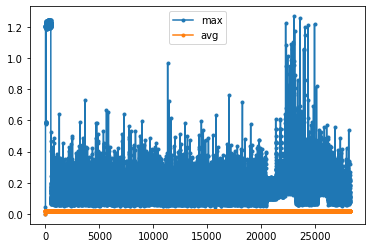

In [ ]:
max_feature, avg_feature = get_tensor_max_avg(train_labels)
plt.plot(max_feature, '.-', label='max')
plt.plot(avg_feature, '.-', label='avg')
plt.legend()

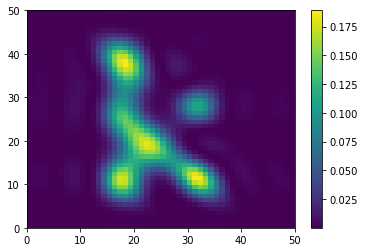

In [ ]:
idx = 20
plt.pcolormesh(alphabet_labels[idx,:,:])
plt.colorbar()

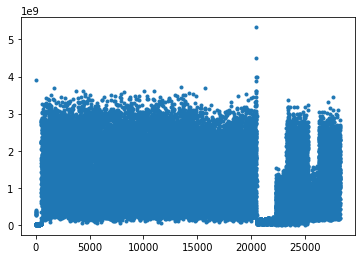

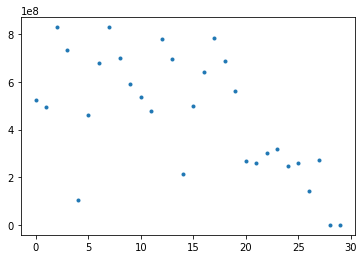

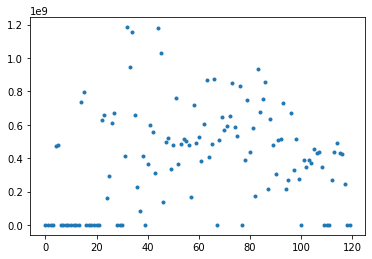

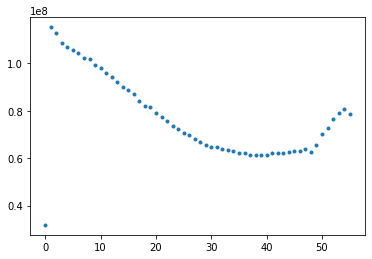

In [ ]:
plt.plot(train_power, '.')
plt.show()

plt.plot(logo_power, '.')
plt.show()

plt.plot(logo_full_power, '.')
plt.show()

plt.plot(lines_power, '.')
plt.show()

In [ ]:
# import matplotlib.cm as cm

# def norm_dist_0_1(a_dist):
#     ''' Normalize a distribution by applying log10 and then rescaling it between 0 and 1 '''
#     log_dist = torch.log10(a_dist)
#     scaled_dist = (log_dist-torch.min(log_dist) ) / ( torch.max(log_dist)-torch.min(log_dist) )
#     return scaled_dist

# def distance_dist(dist_a, dist_b):
#     return dist_a-dist_b

In [ ]:
# mode = 2, 0

# colour_arr = ['k']*100 #['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

# counter = 0
# for m in range(0,1):
#     for n in range(0,16):

#         exp_j_power_m_n = get_power_from_tensor(logo_j_exp, m,n)
#         sim_j_power_m_n = np.nan_to_num(get_power_from_tensor(logo_j_sim, m,n), 0)

#         fig = plt.figure(figsize=(18, 3))
#         plt.ylabel('j power')
#         plt.xlabel('sample idx')
#         plt.title('dataset: logo')

#         plt.subplot(1,3,1)
#         plt.plot( exp_j_power_m_n ,
#                  colour_arr[counter]+'.--',
#                  label='exp, LO: ({},{})'.format(m,n))
#         plt.legend()

#         plt.subplot(1,3,2)
#         plt.plot( sim_j_power_m_n,
#                  colour_arr[counter]+'*-',
#                  label='sim, LO: ({},{})'.format(m,n))
#         plt.legend()

#         plt.subplot(1,3,3)
#         plt.plot( exp_j_power_m_n / exp_j_power_m_n.max() ,
#                  colour_arr[counter]+'.--',
#                  label='exp, LO: ({},{})'.format(m,n))
#         plt.plot( sim_j_power_m_n / sim_j_power_m_n.max() ,
#                  colour_arr[counter]+'*-',
#                  label='sim, LO: ({},{})'.format(m,n))
#         plt.ylabel('j power norm to 1')
#         plt.legend()

#         plt.show()


#         counter+=1

In [ ]:
# load simulated photocurrents

# features_type = 'exp_photocurrents'
# labels_type = 'sim_photocurrents'

# main_folder = "/content/drive/My Drive/HGM_programs/"

# data_folder = features_path + "data_21/" #"data/"

# train_j_exp, train_j_sim = features_and_labels(names,features_type,labels_type)
# logo_j_exp , logo_j_sim = features_and_labels(['logo'],features_type,labels_type)
# alphabet_j_exp, alphabet_j_sim = features_and_labels(['alphabet'],features_type,labels_type)


In [ ]:
# plt.plot(train_j_exp[10009])

# sample_to_check = logo_j_exp

# exp_j_power_m_n = torch.zeros(sample_to_check.shape[0], 16, 16)
# sim_j_power_m_n = torch.zeros(sample_to_check.shape[0], 16, 16)

# for m in range(0,16,1):
#     for n in range(0,16,1):
#         exp_j_power_m_n[:,m,n] = get_power_from_tensor(logo_j_exp, m,n)
#         sim_j_power_m_n[:,m,n] = torch.from_numpy(np.nan_to_num(get_power_from_tensor(logo_j_sim, m,n), 0))

In [ ]:
# ## sample: NI
# samples_idx = 24  #21:'NI', 24:'SI'

In [ ]:
# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

# colormap_palette = cm.Blues

# plt.subplot(1,3,1)
# plt.pcolormesh( norm_dist_0_1(exp_j_power_m_n[samples_idx,:,:] ),
#                 cmap=colormap_palette)
# plt.title('EXP DATA / sample ({}) norm j power'.format(samples_idx) )
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(shrink=1, aspect=15, orientation='horizontal')
# plt.xlabel('m')
# plt.ylabel('n')

# plt.subplot(1,3,2)
# plt.pcolormesh( norm_dist_0_1( sim_j_power_m_n[samples_idx,:,:]),
#                cmap=colormap_palette)

# plt.title('SIM DATA / sample ({}) norm j power'.format(samples_idx) )
# plt.gca().set_aspect('equal', adjustable='box')
# m = plt.cm.ScalarMappable(cmap=colormap_palette)
# plt.colorbar(m, shrink=1, aspect=15, orientation='horizontal')

# plt.xlabel('m')
# plt.ylabel('n')

# distance_exp_sim = distance_dist( norm_dist_0_1(exp_j_power_m_n[samples_idx,:,:] ) , norm_dist_0_1( sim_j_power_m_n[samples_idx,:,:]))

# plt.subplot(1,3,3)

# plt.pcolormesh( np.abs(distance_exp_sim), cmap=colormap_palette)
# plt.title('sample ({}) exp-sim distribution distance'.format(samples_idx) )
# m = plt.cm.ScalarMappable(cmap=colormap_palette)
# m.set_array(distance_exp_sim)
# z_min, z_max = 0, 1
# m.set_clim(z_min, z_max)
# plt.colorbar(m, shrink=1, aspect=15, orientation='horizontal', boundaries=np.linspace(z_min, z_max, 16))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlabel('m')
# plt.ylabel('n')


We notice that experimental projections for even order modes are more similar to the theoretical projections than in the case of odd order modes i.e. (1,0) or (3,0)